In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import random_split

In [57]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)


test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)



In [58]:
train_dataset_data = train_dataset.data
train_dataset_target = train_dataset.targets
print(train_dataset_data.size())
print(train_dataset_target.size())


test_dataset_data = test_dataset.data
test_dataset_target = test_dataset.targets

torch.Size([60000, 28, 28])
torch.Size([60000])


In [59]:
train_dataset_target_us = train_dataset_target.unsqueeze(1)
train_onehot_labels = torch.zeros(train_dataset_data.size(0), 10)
train_onehot_labels.scatter_(1, train_dataset_target_us, 1)

test_dataset_target_us = test_dataset_target.unsqueeze(1)
test_onehot_labels = torch.zeros(test_dataset_data.size(0), 10)
test_onehot_labels.scatter_(1, test_dataset_target_us, 1)

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [60]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_dataset_data, train_onehot_labels), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_dataset_data, test_onehot_labels), batch_size=64, shuffle=False)

In [61]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = x.float()
        logits = self.linear_relu_stack(x)
        out = F.softmax(logits, dim=1)
        return out

In [63]:
class SGD:
    def __init__(self, parameters, lr=0.01):
        self.params = parameters
        self.lr = lr

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            param.grad = None


In [64]:
class Momentum:
    def __init__(self, parameters, lr=0.01, momentum=0.9):
        self.params = parameters
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(param) for param in self.params]

    def step(self):
        for i, param in enumerate(self.params):
            self.velocities[i] = self.momentum * self.velocities[i] + self.lr * param.grad
            param -= self.velocities[i]

    def zero_grad(self):
        for param in self.params:
            param.grad = None


In [65]:
class NAG:
    def __init__(self, parameters, lr=0.01, momentum=0.9):
        self.params = parameters
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(param) for param in self.params]

    def step(self):
        for i, param in enumerate(self.params):
            self.velocities[i] = self.momentum * self.velocities[i] - self.lr * param.grad
            param += self.momentum * self.momentum * self.velocities[i] - (1 + self.momentum) * self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            param.grad = None


In [66]:
class AdaGrad:
    def __init__(self, parameters, lr=0.01, eps=1e-8):
        self.params = parameters
        self.lr = lr
        self.eps = eps
        self.sum_squared_grad = [torch.zeros_like(param) for param in self.params]

    def step(self):
        for i, param in enumerate(self.params):
            self.sum_squared_grad[i] += param.grad ** 2
            param -= self.lr * param.grad / (torch.sqrt(self.sum_squared_grad[i]) + self.eps)

    def zero_grad(self):
        for param in self.params:
            param.grad = None


In [67]:
class RMSprop:
    def __init__(self, parameters, lr=0.01, beta=0.9, eps=1e-8):
        self.params = parameters
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.avg_squared_grad = [torch.zeros_like(param) for param in self.params]

    def step(self):
        for i, param in enumerate(self.params):
            self.avg_squared_grad[i] = self.beta * self.avg_squared_grad[i] + (1 - self.beta) * (param.grad ** 2)
            param -= self.lr * param.grad / (torch.sqrt(self.avg_squared_grad[i]) + self.eps)

    def zero_grad(self):
        for param in self.params:
            param.grad = None


In [68]:
class Adam:
    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = parameters
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [torch.zeros_like(param) for param in self.params]
        self.v = [torch.zeros_like(param) for param in self.params]

    def step(self):
        for i, (param, grad) in enumerate(zip(self.params, [p.grad for p in self.params])):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            m_hat = self.m[i]
            v_hat = self.v[i]
            param -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for param in self.params:
            param.grad = None


In [69]:
class AdamBias:
    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = parameters
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [torch.zeros_like(param) for param in self.params]
        self.v = [torch.zeros_like(param) for param in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, (param, grad) in enumerate(zip(self.params, [p.grad for p in self.params])):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            param -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for param in self.params:
            param.grad = None


In [71]:


def train_model(model,optimizer,train_loader,val_loader, epochs=2, lr = 0.0001):
  epochs = epochs
  lrate = lr


  for ep in range(epochs):
      model.train()

      train_loss = 0.0
      for x, y in train_loader:
          x, y = x, y.float()  # Convert y to float


          model.zero_grad()
          out = model(x)


          loss = F.mse_loss(out, y)
          loss.backward()

          train_loss += loss
          optimizer.step()


      model.eval()

      val_loss = 0.0
      for x, y in test_loader:
          x, y = x, y.float()

          out = model(x)

          out = torch.argmax(out, dim=1).float()
          y = torch.argmax(y, dim=1).float()
          loss = F.mse_loss(out, y)

          val_loss += loss

      if ep%10 == 0:
          print('\n%10d %20.5e %20.5e\n'%(ep,
                  train_loss.item()/(ntrain/batchsize),
                  val_loss.item()/(nval/val_bs)))

          plt.figure(figsize=[10,4])
          plt.plot(out.detach().cpu().numpy(),'o',label='pred',markersize=8.5)
          plt.plot(y.detach().cpu().numpy(),'.',label='true',markersize=8.5)
          plt.xlabel(f'validation samples (after epoch {ep})',fontsize = 18)
          plt.legend(fontsize=18, loc='upper right')
          plt.show()


         0          1.20289e+00          3.08191e+01



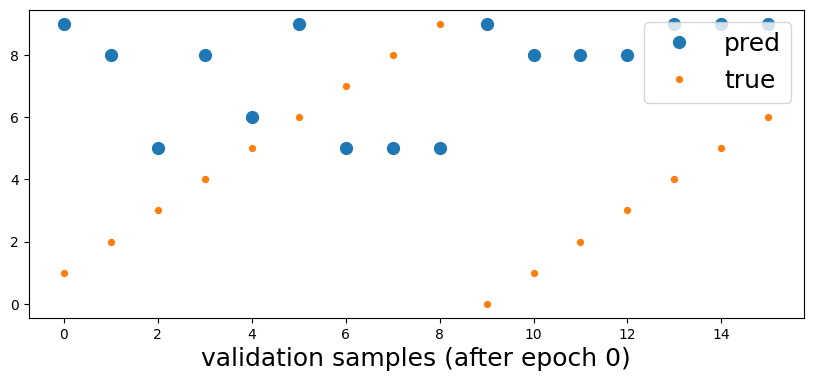

In [78]:
ntrain = 60000
nval = 10000
ntest = 10000

batchsize = 500
val_bs = 100
tst_bs = 100


lrate = 0.0001

# Initialize the model
model = NeuralNetwork()

# Initialize the optimizer
# optimizer = torch.optim.Adam(
#                   model.parameters(),
#                   lr=lrate)

# optimizer = SGD(model.parameters())
# optimizer = Momentum(model.parameters())
# optimizer = NAG(model.parameters())
# optimizer = AdaGrad(model.parameters())
# optimizer = RMSprop(model.parameters())
# optimizer = Adam(model.parameters())
optimizer = AdamBias(model.parameters())


train_model(model, optimizer, train_loader, test_loader)